In [1]:
from Audiofile import Audiofile
from OLTW import OLTW
from Feature import *
from Annotation import Annotation
from AudioStream import AudioStream
from Queueing import Queueing
from Connector import Connector

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.colors as colors
import sys

In [3]:
# Set parameters
fs = 48000 # Frequency
fl = 250 # Frame length
hopl = 100 # Hop length (ms); determines frames/s
endtime = 15000 # (s)
searchwidth = 300 # frames

In [4]:
# Load audio
reference = Audiofile(".../.wav", fs)
target = Audiofile(".../.wav", fs)

In [5]:
# Load queueing reference
q = Queueing(Connector())
q.loadCSV(".../.csv" )

In [6]:
# Define a step function that is executed every frame
def step(target_timestamp, reference_timestamp):

    chunk = q.checkTimestamp(reference_timestamp)
    sys.stdout.write('\r'+f'target: {target_timestamp}, ref: {reference_timestamp}, chunk: {chunk}')

In [7]:
# Initialize the OLTW algorithm
mfcc = LibrosaMFCC(fs,fl,hopl, ncoeff=120, cskip=20)
oltw = OLTW(mfcc, inc_measure='weightedmean', searchwidth=searchwidth, matrixsize=14000, save_analytics=True, start_deadzone=0, use_future=False, n_frames=36000, d_measure='manhattan', delin='axes', diagonalCost=1.41)
oltw.loadReference(reference.signal)
oltw.init()

In [8]:
# Simulate a performance
auds = AudioStream(fs, fl, hopl, oltw.processFrame, queueFunc=step)
auds.simulate(target, endtime=endtime, realtime=False)

target: 1050.0, ref: 1032.1, chunk: 104

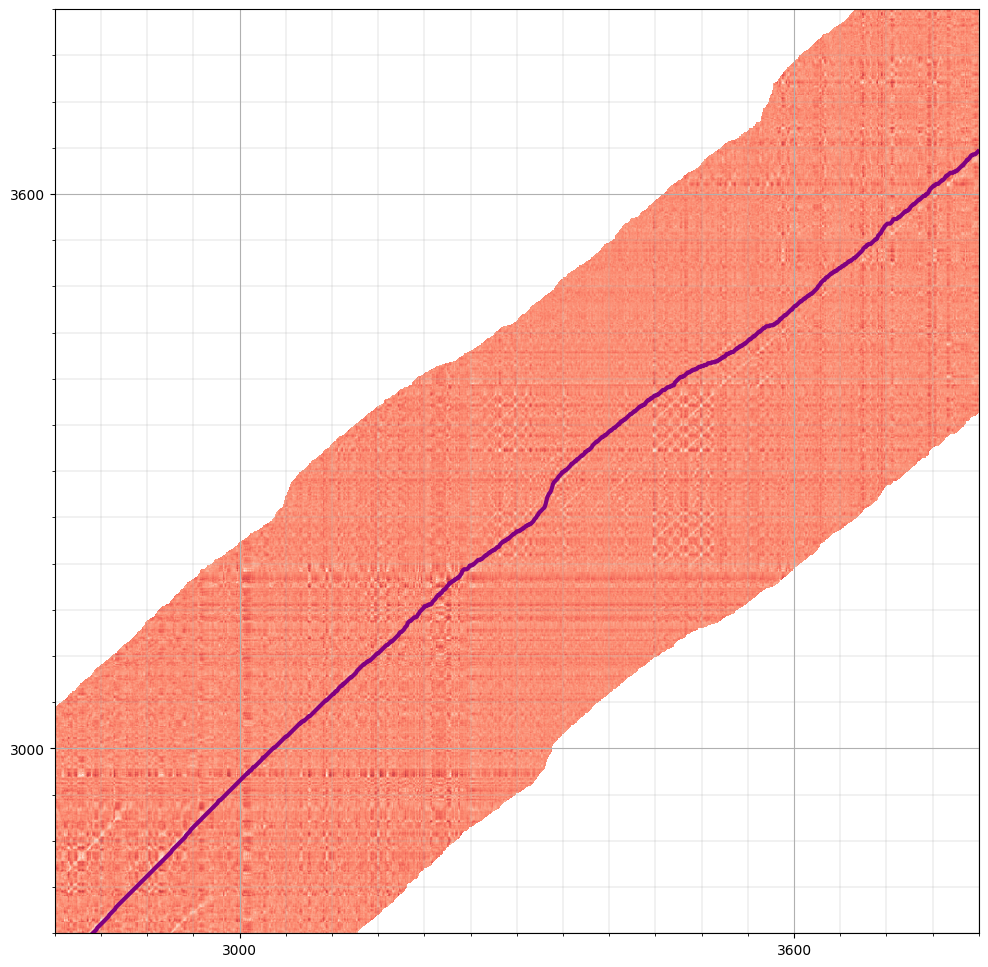

In [32]:
# Plot part of the alignment and cost matrix

p_start = 2800
p_end = 3800

# Cost matrix after (axes method) delinearisation
tlcm = np.copy(oltw.UCM)

# Remove extreme edge values
tlcm[tlcm>10**10] = None
tlcm[tlcm<-10**5] = None

# Plot min-cost-matrix
fig,plot = plt.subplots(1,1,figsize=(12,12))
plot.imshow(tlcm.transpose()[p_start:p_end, p_start:p_end], extent=[p_start, p_end, p_end, p_start], cmap='Reds', alpha=0.8)#, norm=colors.PowerNorm(0.5))
# Overlay alignment
plot.plot(np.arange(p_start, p_end), oltw.alignment[p_start:p_end], label='Base alignment', color='purple', linewidth=3)

# set grid for 5s and minute intervals
plot.xaxis.set_minor_locator(ticker.MultipleLocator(int(1000/hopl)*5))
plot.yaxis.set_minor_locator(ticker.MultipleLocator(int(1000/hopl)*5))
plot.xaxis.set_major_locator(ticker.MultipleLocator(int(1000/hopl)*60))
plot.yaxis.set_major_locator(ticker.MultipleLocator(int(1000/hopl)*60))
plot.set_ylim(p_start, p_end)
plot.grid(which='minor', linewidth=0.25)
plot.grid()